In [ ]:
!pip install accelerate -Uq

exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets transformers evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.2 MB/s eta 0:00:00


In [ ]:
from transformers import set_seed
import os
import random
import numpy as np

import torch

def set_all_seeds(seed=22):

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


magic_seed = 22
set_all_seeds(seed=magic_seed)

# 6 дней после заражения

## Сделаем Torch Dataset

In [ ]:
# Import libraries

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
import torch

# Mount google drive
from google.colab import drive
drive.mount('gdrive')

In [ ]:
class MultispecDataset(Dataset):
    # create dataset of multispectral images
    def __init__(self, nir_dir, rgb_dir, mask_dir, img_names, transform=None):
        '''
        nir_dir:
            path to NIR images

        rgb_dir:
            path to RGB images

        mask_dir:
            path to masks

        image_names:
            names of images
        '''

        self.nir_dir = nir_dir
        self.rgb_dir = rgb_dir
        self.mask_dir = mask_dir
        self.img_names = img_names
        self.transform = transform

    def __getitem__(self, idx):
        # Open image
        nir_img = Image.open(os.path.join(self.nir_dir, self.img_names[idx]))

        # transform to tensor, change size from [512, 512, 3] to [3, 512, 512]
        # and scale pixel values to range [0, 1]
        nir_img = torch.tensor(np.array(nir_img)).permute((2, 0, 1)) / 255

        rgb_img = Image.open(os.path.join(self.rgb_dir, self.img_names[idx]))
        rgb_img = torch.tensor(np.array(rgb_img)).permute((2, 0, 1)) / 255

        mask = Image.open(os.path.join(self.mask_dir, self.img_names[idx].replace('JPG', 'png')))

        # transform if desired
        if self.transform:
            nir_img = self.transform(nir_img)

        # concatenate images to get the multispectral one
        image = torch.cat([nir_img, rgb_img], axis=0)

        return {'pixel_values': image, 'labels': torch.tensor(np.array(mask) / 255).long()}

    def __len__(self):
        return len(self.img_names)

In [ ]:
id2label = {0: 'unlabeled', 1: 'leaf-disease'}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

In [ ]:
from transformers import SegformerImageProcessor

model_checkpoint =  "nvidia/mit-b2"
image_processor = SegformerImageProcessor.from_pretrained(model_checkpoint, do_reduce_labels=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future v

In [ ]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std
image_size = image_processor.size

print('image_mean:', image_mean)
print('image_std:', image_std)
print('image_size:',image_size)

image_mean: [0.485, 0.456, 0.406]
image_std: [0.229, 0.224, 0.225]
image_size: {'height': 512, 'width': 512}


In [ ]:
image_transforms = transforms.Compose([
    #transforms.Resize(size=(image_size['height'], image_size['width'])),
                                       transforms.Normalize(mean=image_mean,std=image_std)])

In [ ]:
# Image directories
nir_dir = '/content/gdrive/MyDrive/Cropped Potato/2023_ИК_больные/6 дней после заражения'
rgb_dir = '/content/gdrive/MyDrive/Cropped Potato/2023_ВИД_больные/6 дней после заражения'
mask_dir = '/content/gdrive/MyDrive/Cropped Potato/Разметка/6 дней после заражения/Разметка картинки'

In [ ]:
rgb_images = os.listdir(rgb_dir)
mask_images = os.listdir(mask_dir)

In [ ]:
# 0.7 : 0.15 : 0.15
num_train_samples = 945
num_validation_samples = 210
num_test_samples = len(rgb_images) - num_train_samples - num_validation_samples # 189

In [ ]:
train_images = rgb_images[:num_train_samples]
train_masks = mask_images[:num_train_samples]

val_images = rgb_images[num_train_samples:(num_train_samples + num_validation_samples)]
val_masks = mask_images[num_train_samples:(num_train_samples + num_validation_samples)]

test_images = rgb_images[(num_train_samples + num_validation_samples):]
test_masks = mask_images[(num_train_samples + num_validation_samples):]

In [ ]:
print(len(train_images), len(train_masks))
print(len(val_images), len(val_masks))
print(len(test_images), len(test_masks))

945 945
210 210
189 189


In [ ]:
train_dataset = MultispecDataset(nir_dir, rgb_dir, mask_dir, train_images, image_transforms)
val_dataset = MultispecDataset(nir_dir, rgb_dir, mask_dir, val_images, image_transforms)

## Train

In [ ]:
!pip install segmentation-models-pytorch -q

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
from transformers import Trainer

# Dice Loss
class DiceTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        logits_tensor = nn.functional.interpolate(
        logits,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
        )

        disease_logits = logits_tensor[:, 1, :, :]

        loss_fct = DiceLoss(mode='binary')
        loss = loss_fct(disease_logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.wei

In [ ]:
import torch.nn as nn
# Change model architecture so that it will be able to work with multispectral (6-channels) images
model.segformer.encoder.patch_embeddings[0].proj = nn.Conv2d(6, 64,
                                                             kernel_size=(7, 7),
                                                             stride=(4, 4),
                                                             padding=(3, 3))


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

27357570

In [ ]:
from sklearn.metrics import cohen_kappa_score

def calculate_cohen_kappa(y_true, y_pred):
  return cohen_kappa_score(y_true.flatten(), y_pred.flatten())

In [ ]:
import torch
from torch import nn
import evaluate
from matplotlib import pyplot as plt

metric = evaluate.load("mean_iou")
sigma = nn.Sigmoid()

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred


    logits_tensor = torch.from_numpy(logits)

    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).detach().cpu().numpy()

    disease_logits = logits_tensor[:, 1, :, :]

    disease_sigmoid = sigma(torch.tensor(disease_logits))

    pred_labels = (disease_sigmoid > 0.5).int()


    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=-1,
            reduce_labels=False,
        )





    eval_iou = metrics['per_category_iou'][1]
    metrics = {'eval_IoU': eval_iou}
    metrics['eval_Dice'] = eval_iou * 2 / (eval_iou + 1)
    metrics['eval_kappa_score'] = calculate_cohen_kappa(labels, pred_labels)
    metrics['eval_mean'] = (metrics['eval_IoU'] + metrics['eval_kappa_score']) / 2
    return metrics

In [ ]:
from transformers import TrainingArguments, get_linear_schedule_with_warmup
from torch.optim import AdamW

# best parameters according to tuning
best_params = {'betta_1': 0.7871, 'betta_2': 0.526, 'lr': 0.0009022,
               'num_warmup_steps': 175 * 10, 'smooth': 0.3177, 'weight_decay': 0.0275}

# num_warmup_steps = 175 corresponds to 5 epochs. Change this value proportionally

epochs = 50
lr = best_params['lr']
batch_size = 8


num_warmup_steps = best_params['num_warmup_steps']
num_training_steps = len(train_dataset) // batch_size * epochs

optimizer = AdamW(model.parameters(), lr=lr, betas=(best_params['betta_1'], best_params['betta_2']),
                  weight_decay=best_params['weight_decay'])
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

hub_model_id = "segformer-b2-finetuned-potato-late-blight"

training_args = TrainingArguments(
    "segformer-b2-finetuned-potato-late-blight",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_mean',
    greater_is_better=True,
    push_to_hub=True,
    remove_unused_columns=False,
    seed=magic_seed,
    hub_model_id=hub_model_id,
    hub_private_repo=True,
    hub_strategy="end",
)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, default_data_collator

trainer = DiceTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor, # also need to push it
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

In [ ]:
train_results = trainer.train()

# save states and log metrics
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

events.out.tfevents.1716048278.55128943c212.1159.8:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

events.out.tfevents.1716048637.55128943c212.1159.9:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

events.out.tfevents.1716048792.55128943c212.62787.0:   0%|          | 0.00/6.61k [00:00<?, ?B/s]

events.out.tfevents.1716049008.55128943c212.62787.1:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

## Inference on test set (это вынести можно в отдельный блокнот)

In [ ]:
# Create test dataset
test_dataset = MultispecDataset(nir_dir, rgb_dir, mask_dir, test_images, image_transforms)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
from random import randint
from tqdm.auto import tqdm
import torch.nn as nn

kappa_score = 0
sigma = nn.Sigmoid()
with torch.no_grad():
    for batch in tqdm(test_loader):
        pix_vals = batch['pixel_values'].to(device)
        labels = batch['labels']

        outputs = model(pixel_values=pix_vals)
        logits = outputs.logits.cpu()

        upsampled_logits = nn.functional.interpolate(
        logits,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,)

        disease_logits = upsampled_logits[:, 1, :, :]
        disease_sigmoid = sigma(torch.tensor(disease_logits))
        # 0.0001 - threshold
        pred_labels = (disease_sigmoid > 0.0001).int()  # - IoU = 0.413

        metric.add_batch(predictions=pred_labels, references=labels)
        kappa_score += calculate_cohen_kappa(y_true=labels, y_pred=pred_labels)

kappa_score /= len(test_loader)


In [ ]:
test_iou = metric.compute(num_labels=len(id2label),
               ignore_index=-1, reduce_labels=image_processor.do_reduce_labels)#['per_category_iou'][1]

disease_iou = test_iou['per_category_iou'][1]

In [ ]:
print('test_iou:', test_iou)

In [ ]:
test_dice = disease_iou * 2 / (disease_iou + 1)

In [ ]:
print(f'test_iou = {disease_iou}, test_dice = {test_dice}, test_kappa = {kappa_score}') # Для segformer-b2

In [ ]:
test_iou

{'mean_iou': 0.703118706856571,
 'mean_accuracy': 0.773750918468787,
 'overall_accuracy': 0.9935283358134921,
 'per_category_iou': array([0.99349877, 0.41273865]),
 'per_category_accuracy': array([0.99722261, 0.55027923])}

In [ ]:
disease_iou, test_dice, kappa_score # Test metrics

(0.4127386481853214, 0.5843099836130183, 0.572567080340087)

## Visualize some predictions

### Val dataset

<ipython-input-117-fc9db8692a0f>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  disease_sigmoid = sigma(torch.tensor(disease_logits))


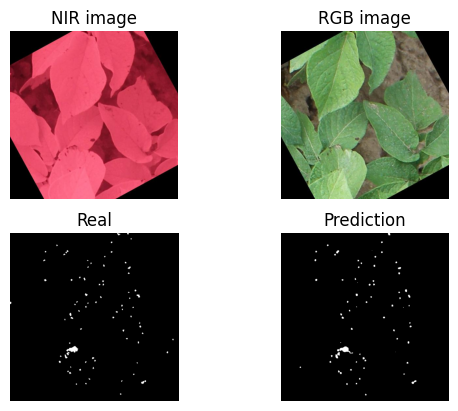

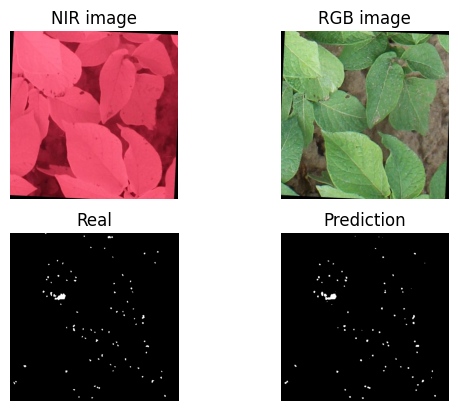

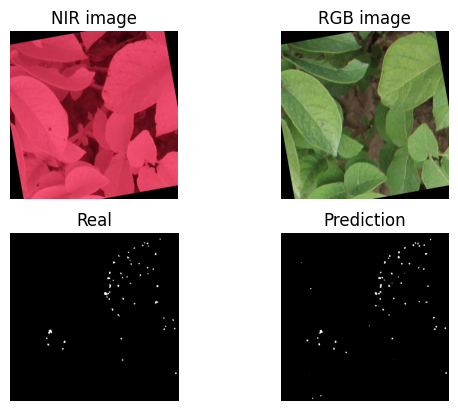

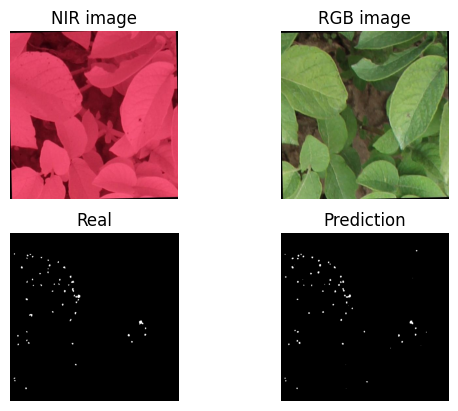

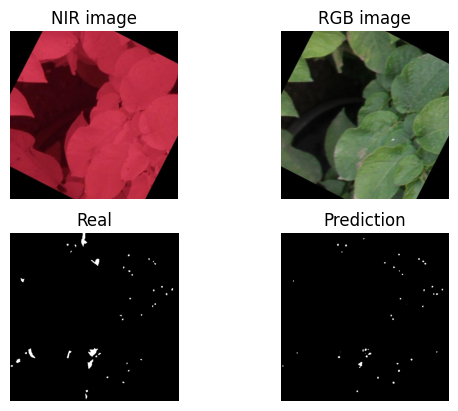

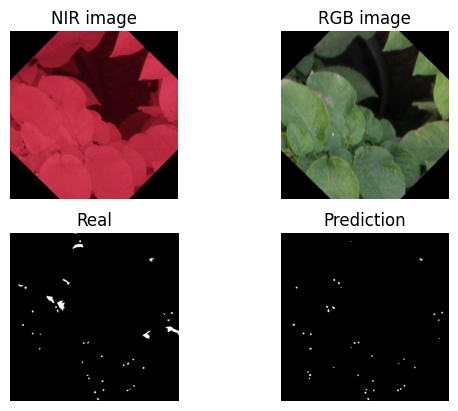

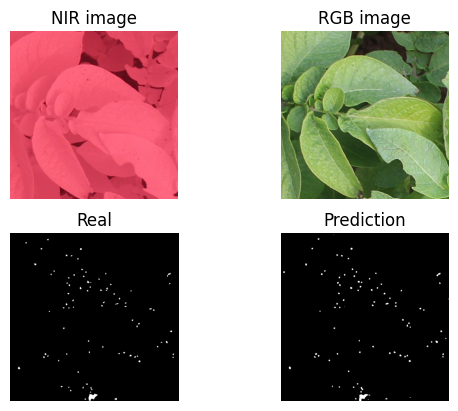

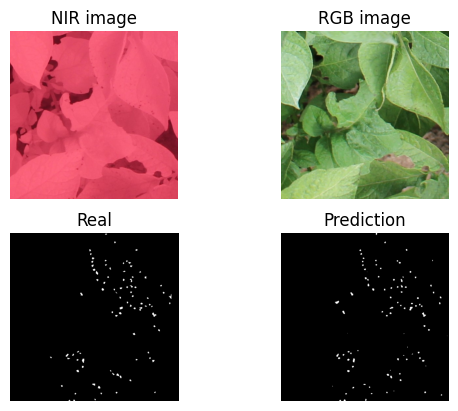

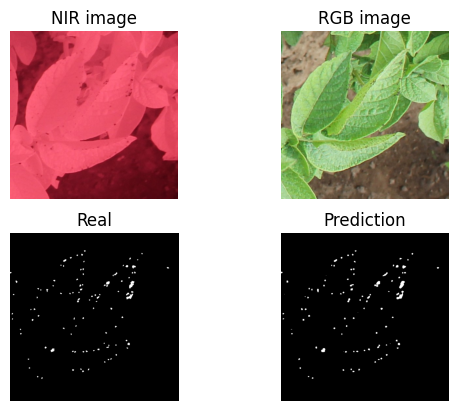

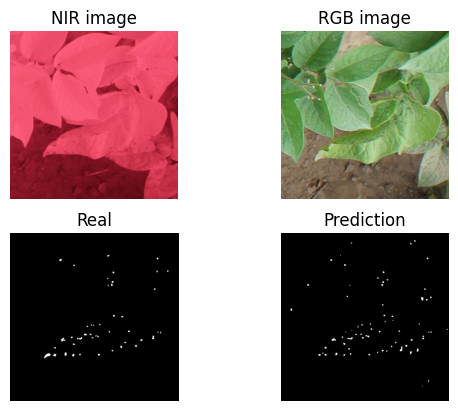

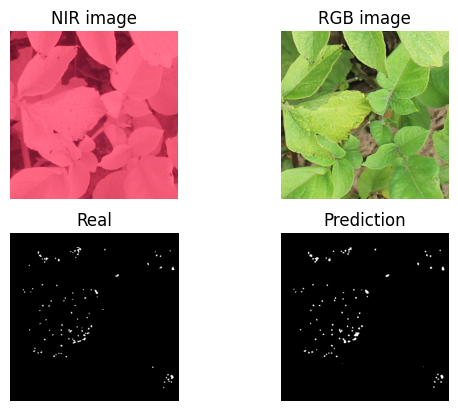

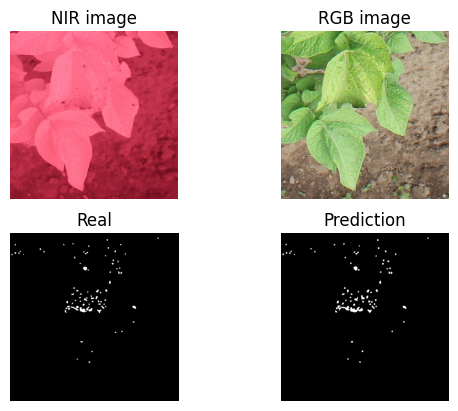

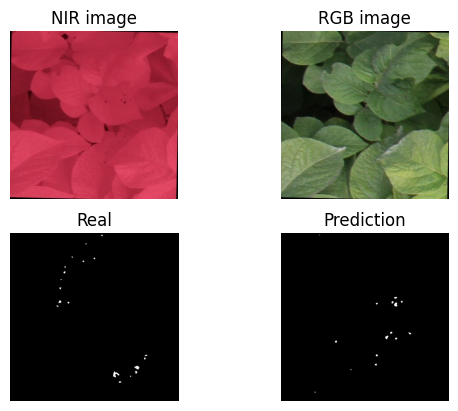

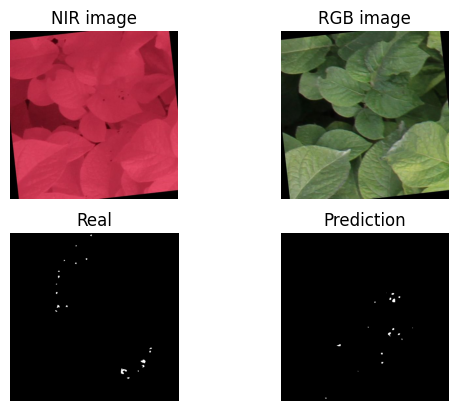

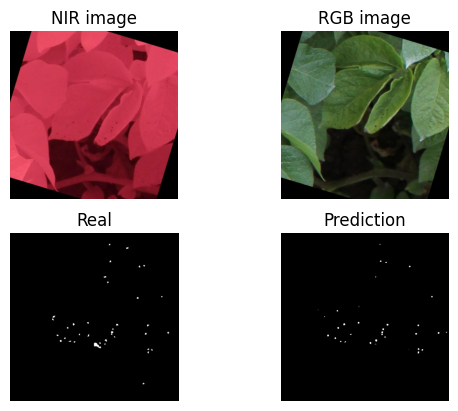

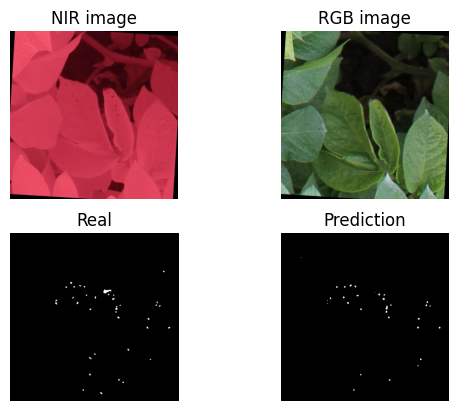

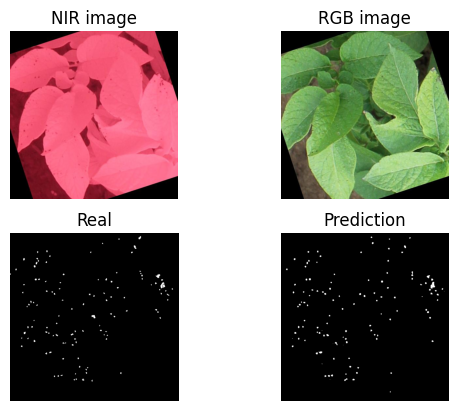

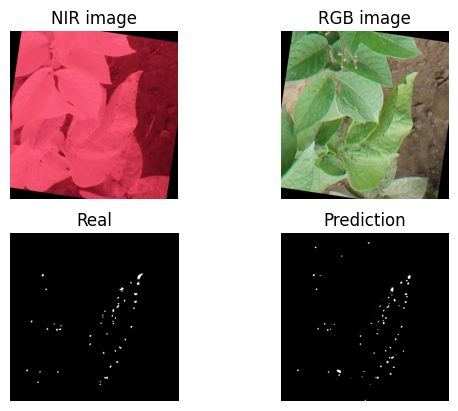

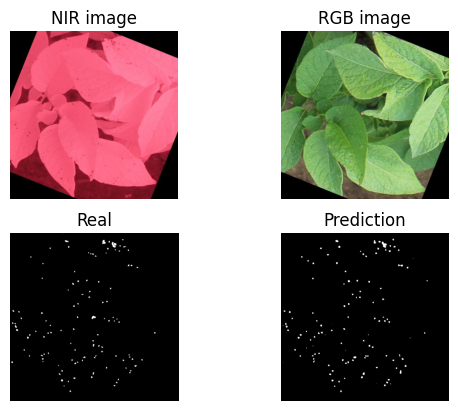

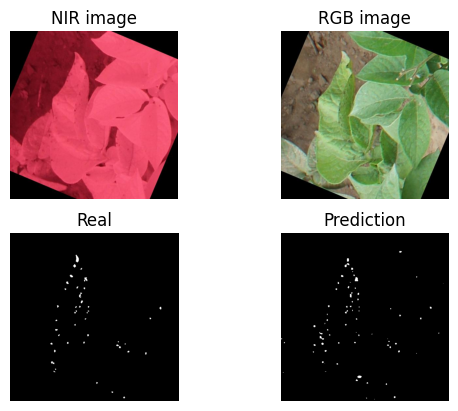

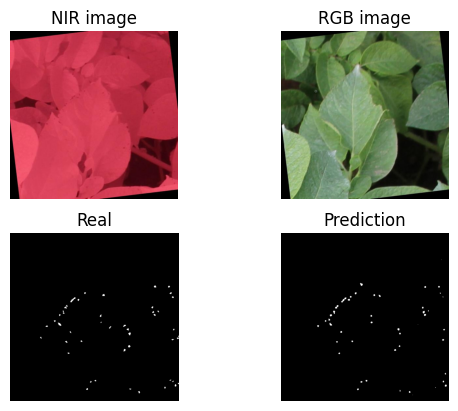

In [ ]:
for i, batch in enumerate(val_dataset):
    if i % 10 == 1:

        pix_vals = batch['pixel_values'].to(device)

        nir_img = Image.open(os.path.join(nir_dir, val_images[i]))
        nir_img = torch.tensor(np.array(nir_img)).permute((2, 0, 1)) / 255

        rgb_img = Image.open(os.path.join(rgb_dir, val_images[i]))
        rgb_img = torch.tensor(np.array(rgb_img)).permute((2, 0, 1)) / 255

        labels = batch['labels'].to(device)

        print(labels.shape)
        outputs = model(pix_vals.unsqueeze(0).to(device))

        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        disease_logits = logits_tensor[:, 1, :, :]
        disease_sigmoid = sigma(torch.tensor(disease_logits))
        pred_labels = (disease_sigmoid > 0.1).int()  # - IoU = 0.399

        plt.subplot(2, 2, 1)
        plt.imshow(nir_img.permute((1, 2, 0)).detach().cpu().numpy())
        plt.title('NIR image')
        plt.axis('off')


        plt.subplot(2, 2, 2)
        plt.imshow(rgb_img.permute((1, 2, 0)).detach().cpu().numpy())
        plt.title('RGB image')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(labels.detach().cpu().numpy(), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(pred_labels[0].detach().cpu().numpy(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.show()


### Test dataset

<ipython-input-128-deba57ed16bb>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  disease_sigmoid = sigma(torch.tensor(disease_logits))


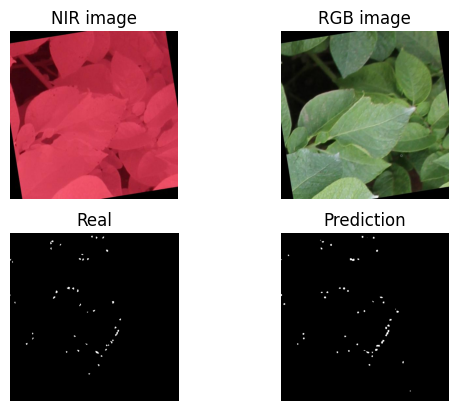

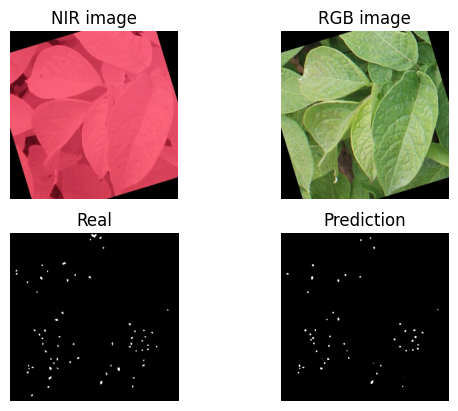

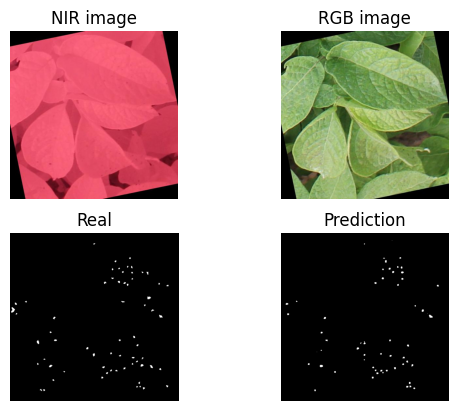

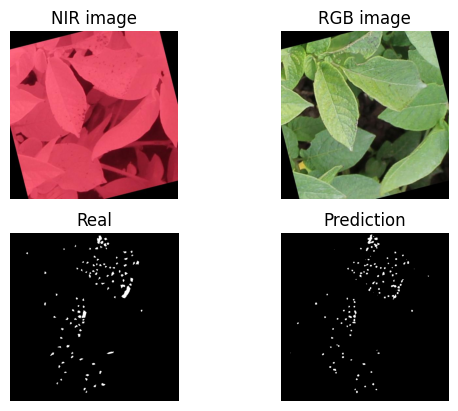

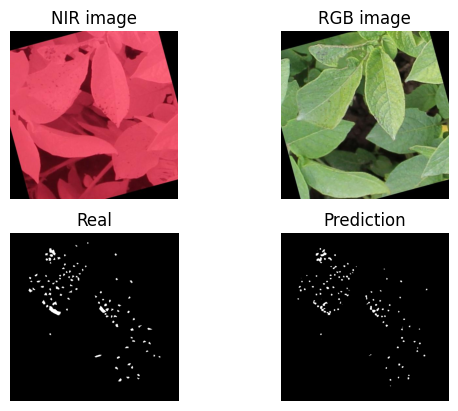

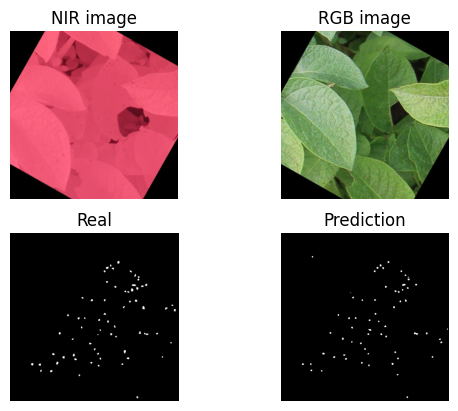

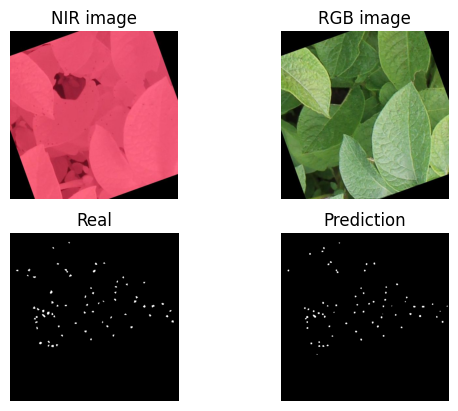

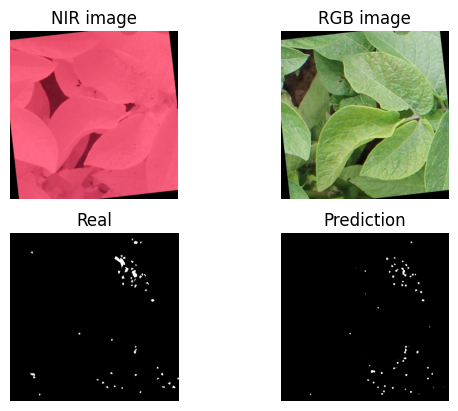

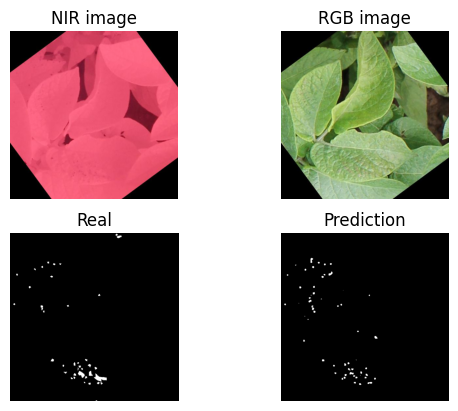

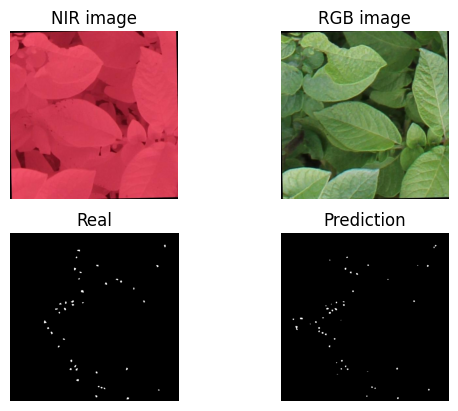

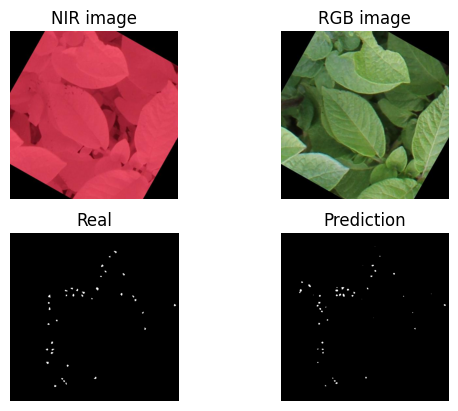

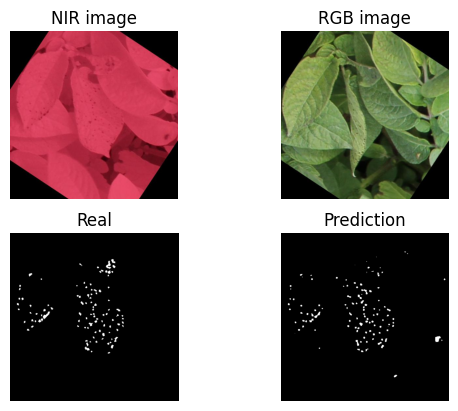

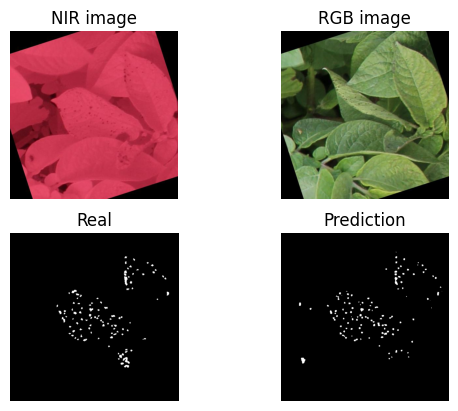

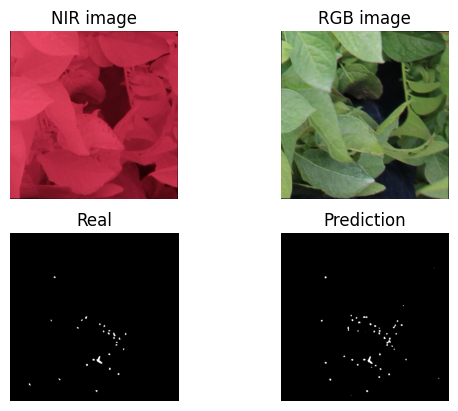

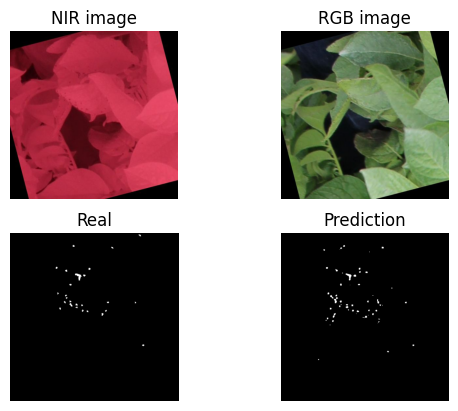

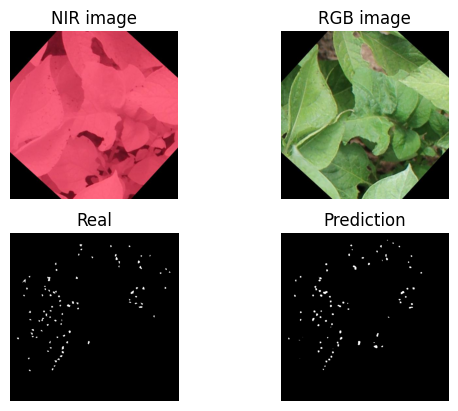

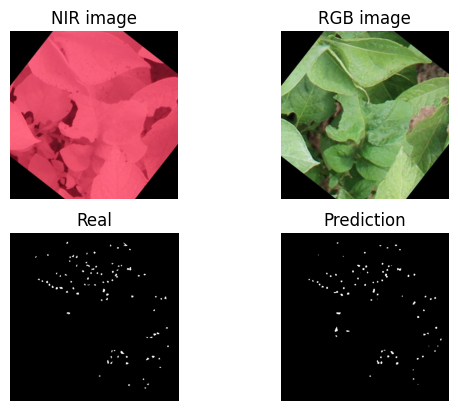

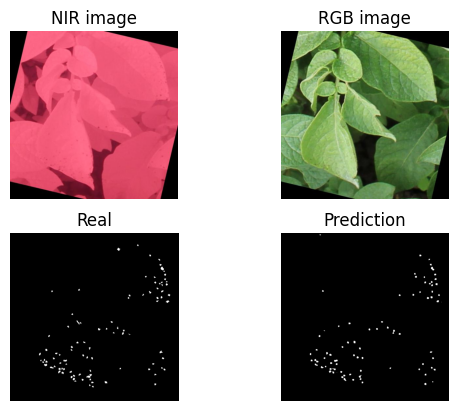

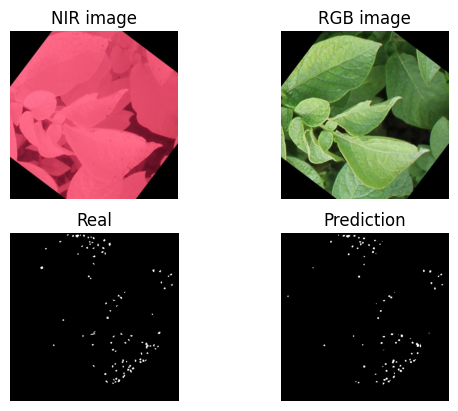

In [ ]:
for i, batch in enumerate(test_dataset):
    if i % 10 == 1:

        pix_vals = batch['pixel_values'].to(device)

        nir_img = Image.open(os.path.join(nir_dir, test_images[i]))
        nir_img = torch.tensor(np.array(nir_img)).permute((2, 0, 1)) / 255

        rgb_img = Image.open(os.path.join(rgb_dir, test_images[i]))
        rgb_img = torch.tensor(np.array(rgb_img)).permute((2, 0, 1)) / 255

        labels = batch['labels'].to(device)

        print(labels.shape)
        outputs = model(pix_vals.unsqueeze(0).to(device))

        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        disease_logits = logits_tensor[:, 1, :, :]
        disease_sigmoid = sigma(torch.tensor(disease_logits))
        pred_labels = (disease_sigmoid > 0.0001).int()  # - IoU = 0.413

        plt.subplot(2, 2, 1)
        plt.imshow(nir_img.permute((1, 2, 0)).detach().cpu().numpy())
        plt.title('NIR image')
        plt.axis('off')


        plt.subplot(2, 2, 2)
        plt.imshow(rgb_img.permute((1, 2, 0)).detach().cpu().numpy())
        plt.title('RGB image')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(labels.detach().cpu().numpy(), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(pred_labels[0].detach().cpu().numpy(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.show()
